## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important to get some practice working with the difficulties of these.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import the libraries.

In [1]:
# to download the data
import requests
import zipfile
from io import BytesIO
import os

# for the analysis
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

> Download the data

In [4]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/December/5a32c9a0_analyzeabtestresults-2/analyzeabtestresults-2.zip"

# download data
req = requests.get(url)
file = zipfile.ZipFile(BytesIO(req.content))

# extract file
file.extract("AnalyzeABTestResults 2/ab_data.csv")
file.extract("AnalyzeABTestResults 2/countries.csv")

# clean up
os.rename("AnalyzeABTestResults 2/ab_data.csv", "ab_data.csv")
os.rename("AnalyzeABTestResults 2/countries.csv", "countries.csv")
os.rmdir("AnalyzeABTestResults 2")

> Read the dataset and look at some generic information

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
print(f"The dataset contains {df.shape[0]} rows")

The dataset contains 294478 rows


In [4]:
print(f"There are {df.user_id.unique().shape[0]} unique users in the dataset")

There are 290584 unique users in the dataset


In [5]:
# check how many times on average there is a duplicated user
df[df.user_id.duplicated()].user_id.value_counts().mean()

1.0

In [6]:
# count the occurrences of converted = 1 and converted = 0
not_conv, conv = df.drop_duplicates("user_id").converted.value_counts()

print(f"There are {conv} unique users converted which corresponds to {conv/(conv+not_conv)*100}%")

There are 34745 unique users converted which corresponds to 11.956955647936569%


In [7]:
lineup_err = df.query("(group == 'treatment' and landing_page != 'new_page') or"
                         "(group == 'control' and landing_page != 'old_page')").shape[0]

print(f"There are {lineup_err} rows where the new_page and treatment don't line up.")

There are 3893 rows where the new_page and treatment don't line up.


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


> **All rows contain values as we can see from the Non-Null Count.**

> For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  For this reason we will drop those rows.

In [9]:
df2 = df.query("(group == 'treatment' and landing_page == 'new_page') or"
               "(group == 'control' and landing_page == 'old_page')")

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

> How many unique **user_id**s are in the newly created dataset (df2)?

In [11]:
print(f"There are {df2.user_id.unique().shape[0]} unique users out of {df2.shape[0]} rows")

There are 290584 unique users out of 290585 rows


> Let's find out which is the **user_id** repeated in **df2**.

In [12]:
df2.user_id[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

In [13]:
df2.query("user_id == 773192").head()

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


> At thi point we can remove the duplicate.

In [14]:
df2 = df2.drop(2893)
df2.query("user_id == 773192").head()

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


> What is the probability of an individual converting regardless of the page they receive?

In [15]:
not_conv, conv = df2.converted.value_counts()

print(f"The probability of an individual converting regardless of the page they receive"
      f" is {conv/(conv+not_conv):.4f}")

The probability of an individual converting regardless of the page they receive is 0.1196


> Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
not_conv, conv = df2.query("group == 'control'").converted.value_counts()

print(f"The probability of an individual converting in the control group "
      f"is {conv/(conv+not_conv):.4f}")

The probability of an individual converting in the control group is 0.1204


> Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
not_conv, conv = df2.query("group == 'treatment'").converted.value_counts()

print(f"The probability of an individual converting in the treatment group "
      f"is {conv/(conv+not_conv):.4f}")

The probability of an individual converting in the treatment group is 0.1188


> What is the probability that an individual received the new page?

In [18]:
new, not_new = df2.landing_page.value_counts()

print(f"The probability of an individual receiving the new page "
      f" is {new/(new+not_new):.4f}")

The probability of an individual receiving the new page  is 0.5001


> **We can see that the probability of an individual receiving the new page is ~50%, almost perfectly balanced, so this means that there is no difference in conversion based on giving more opportunities. With that in mind, if we focus our attention on the difference in conversion probability between control and treatment we see a conversion decrease of ~0.16% in the group treatment. This is not yet an evidence since we need to check if this delta is statistically significant. In addition to that, we should also take in consideration the time in which the test run and see if there are influences associated with time.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  

For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, the null and alternative hypotheses would then be

$$H_0: P{new} - P{old} <= 0$$
$$H_1: P{new} - P{old} > 0$$

Let's assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, let's assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

We will now go through a step by step process to perform A/B testing.

> What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

> What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

> What is $n_{new}$?

In [21]:
n_new = len(df2.query("landing_page == 'new_page'"))
n_new

145310

> What is $n_{old}$?

In [22]:
n_old = len(df2.query("landing_page == 'old_page'"))
n_old

145274

> We can now simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.

In [23]:
new_page_converted = np.random.binomial(n_new,p_new)

> We will now simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.

In [24]:
old_page_converted = np.random.binomial(n_old,p_old)

> We now find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
diff = new_page_converted/n_new - old_page_converted/n_old
diff

0.0006241267980694049

> Now we simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process above and Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
iterations = 10000

p_diffs = np.zeros(iterations)
for i in range(10000):
    new_page_converted = np.random.binomial(n_new,p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    p_diffs[i] = new_page_converted/n_new - old_page_converted/n_old

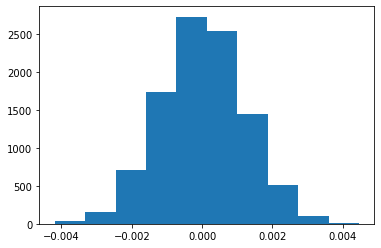

In [28]:
plt.hist(p_diffs);

> What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
# observation difference in ab_data.csv
obs_diff = df2.query("group == 'treatment'").converted.mean() - df2.query("group == 'control'").converted.mean()
print("observation difference: ", obs_diff)

# Compute p-value
print("P-value: ", (p_diffs > obs_diff).mean())

observation difference:  -0.0015782389853555567
P-value:  0.9071


> **We have just calculated the P-value, which is a number describing how likely it is that the data would have occurred under the null hypothesis.**

> **The closest the P-value is to zero, the strongest is the evidence against the null hypothesis. In this case we fail to reject the null hypothesis since the P-value is above 0.05.**

> We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

In [30]:
import statsmodels.api as sm

convert_old = len(df2.query(" landing_page == 'old_page' and converted == 1"))
convert_new = len(df2.query(" landing_page == 'new_page' and converted == 1"))
n_old       = len(df2.query("landing_page == 'old_page'"))
n_new       = len(df2.query("landing_page == 'new_page'"))

In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


> **We can see that we are gatting the same results if we use the statsmodels API. In this case we got in addition the Z-score, which is a numerical measurement that describes a value's relationship to the mean of a group of values and it is measured in terms of numbers of standard deviations from the mean.**

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will see that the result we acheived in the previous A/B test can also be acheived by performing regression.<br><br>

Since each row is either a conversion or no conversion, we will be performing a simple logistic regression.

In [39]:
df2["intercept"] = 1
df2["ab_page"] = pd.get_dummies(df2["group"]).drop("control", axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [40]:
model = sm.Logit(df2.converted,df2[["intercept" ,"ab_page"]])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [41]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 02 Jan 2021   Pseudo R-squ.:               8.077e-06
Time:                        15:09:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

> **P-value = 0.19**

> **In this case we can see that the P-value is different because it considers the null and alternative hypotheses as follow**:

$$H_0: P{new} - P{old} = 0$$
$$H_1: P{new} - P{old} \not = 0$$

> **Since we are testing for the hypothesis to be not equal in this case, also the p-value changes.**

> **Other factors more specifically to the individual's profile might have a stronger influence. For example the age or gender of user and the nationality.**

> **Adding additional terms may bring some disadvantages, for example multicollinearity. If we add high correlations predictor variables, it leads to unreliable and unstable estimates of regression coefficients, which affect our model.**

> Now along with testing if the conversion rate changes for different pages, we will also add an effect based on which country a user lives.

In [42]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [43]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [44]:
df_new[["UK","US"]] = pd.get_dummies(df_new["country"])[["UK","US"]]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


> Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.

In [45]:
model = sm.Logit(df_new.converted, df_new[["intercept", "UK", "US"]])
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 02 Jan 2021   Pseudo R-squ.:               1.521e-05
Time:                        15:23:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [46]:
np.exp(results.params)

intercept    0.130350
UK           1.052027
US           1.041647
dtype: float64

## Conclusion

By analyzing the coefficients in this logistic regression model, we can see a minimal change between the 3 countries. In addition we can see the p-values of UK and US being above 5%.

Based on the evidence found in the data and the same outcome from multiple techniques, we accept the null hypothesis, meaning we have to keep the old page.

**Notice:** The conclusion is derived from the provided data. The conclusion might change if more data from different source would be provided.